In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, MinuteLocator, SecondLocator
from skyfield.api import EarthSatellite, load, wgs84, utc
from scipy.constants import c
import datetime
plt.rcParams['font.size'] = 12

In [2]:
fs = 40e3

sat_names = ['DELFI-PQ', 'EASAT-2', 'HADES']
sats = ['delfi-pq', 'easat-2', 'hades']
channels = ['0x', '0y', '1x', '1y']
x = np.array(
    [[np.fromfile(f'/home/destevez/easat2/extracts_2022-01-16/{sat}_{channel}.c64',
                  'complex64')
      for channel in channels]
     for sat in sats])
T = int(x.shape[-1]/fs)
length = int(T * fs)
x = x[..., :length]
x.shape

(3, 4, 29200000)

In [3]:
ts = load.timescale()
line1 = '1 99489U          22016.00000000  .00000000  00000-0  57534-2 0    09'
line2 = '2 99489  97.5121  85.6393 0012811 246.2946 131.5418 15.14316081    09'
delfi_pq = EarthSatellite(line1, line2, 'DELFI-PQ', ts)
line1 = '1 99489U          22016.00000000  .00000000  00000-0  57534-2 0    09'
line2 = '2 99489  97.5121  85.6393 0012811 246.2946 132.0566 15.14316081    09'
easat2 = EarthSatellite(line1, line2, 'EASAT-2', ts)
line1 = '1 99489U          22016.00000000  .00000000  00000-0  57534-2 0    09'
line2 = '2 99489  97.5121  85.6393 0012811 246.2946 131.6880 15.14316081    03'
hades = EarthSatellite(line1, line2, 'HADES', ts)
tles = [delfi_pq, easat2, hades]
ata = wgs84.latlon(40.8175, -121.4733, 1008)

In [4]:
t0 = 1642355550.155110
t0_dt = datetime.datetime(1970, 1, 1, tzinfo=utc) + datetime.timedelta(seconds=t0)
t0_ts = ts.utc(t0_dt.year, t0_dt.month, t0_dt.day, t0_dt.hour, t0_dt.minute, t0_dt.second)
doppler_T = 0.1
dts = np.arange(int(T / doppler_T)) * doppler_T
times = ts.from_datetimes([t0_dt + datetime.timedelta(seconds=dt) for dt in dts])

In [5]:
t0_dt

datetime.datetime(2022, 1, 16, 17, 52, 30, 155110, tzinfo=datetime.timezone.utc)

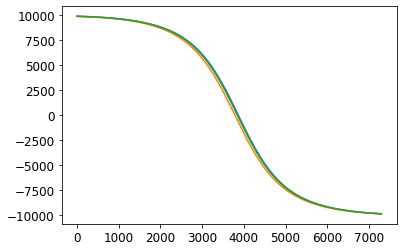

In [6]:
f_carrier = 436.5e6
range_rates = np.array([
    (sat - ata).at(times).frame_latlon_and_rates(ata)[-1].m_per_s
    for sat in tles])
dopplers = -range_rates/c*f_carrier
plt.plot(dopplers.T);

In [7]:
doppler_interps = np.array([
    np.interp(np.arange(length)/fs, dts, doppler)
    for doppler in dopplers])
phases = 2*np.pi*np.cumsum(doppler_interps/fs, axis=-1)
y = np.exp(-1j*phases)[:, np.newaxis, :] * x

In [8]:
NFFT = 2**12
w = np.blackman(NFFT)
yy = y[..., :length//NFFT*NFFT].reshape(y.shape[:-1] + (-1, NFFT))
f = np.fft.fftshift(np.fft.fft(yy * w), axes=-1)
f.shape

(3, 4, 7128, 4096)

In [9]:
noise_measure_sel = slice(0, NFFT//4)
noise = np.average(np.abs(f[0, ..., noise_measure_sel])**2, axis=(-1,-2))
noise

array([0.00044378, 0.00051366, 0.00053581, 0.00652447])

In [10]:
f_norm = f / np.sqrt(noise)[:, np.newaxis, np.newaxis]
f_sat = np.average(np.abs(f_norm)**2, axis=1)

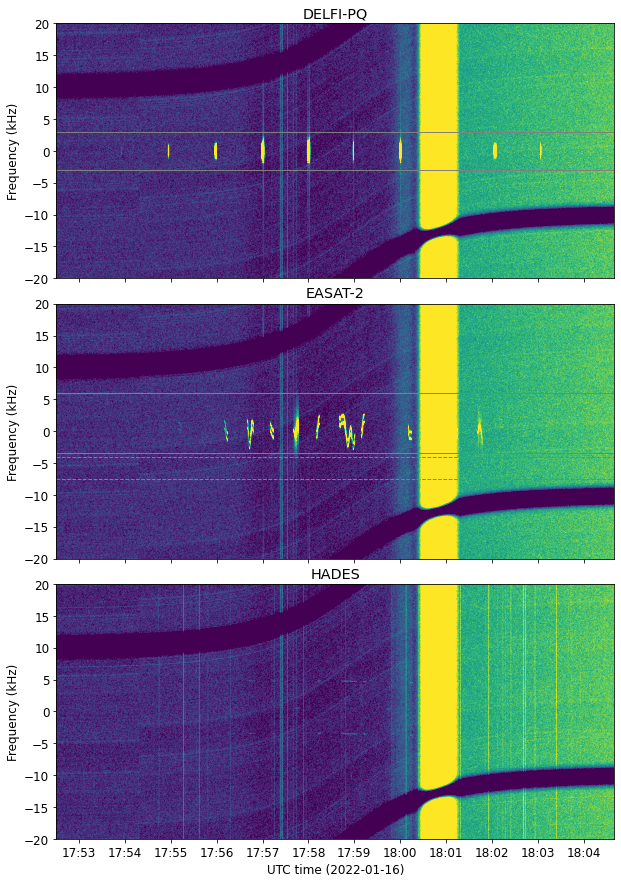

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15), facecolor='w', sharex=True)
for name, sat, ax in zip(sat_names, f_sat, axs):
    ax.imshow(10*np.log10(sat).T[::-1], aspect='auto',
               extent=[mdates.date2num(t0_dt), mdates.date2num(t0_dt + datetime.timedelta(seconds=T)),
                       -fs/2*1e-3, fs/2*1e-3],
               vmin=-3, vmax=2)
    ax.set_title(name)
    ax.set_ylabel('Frequency (kHz)')
axs[0].axhline(y=-3, color='gray', linewidth=1)
axs[0].axhline(y=3, color='gray', linewidth=1)
axs[1].axhline(y=6, color='gray', linewidth=1)
axs[1].axhline(y=-3.5, color='gray', linewidth=1)
axs[1].axhline(y=-4, linestyle='--', color='gray', linewidth=1)
axs[1].axhline(y=-7.5, linestyle='--', color='gray', linewidth=1)
axs[-1].xaxis.set_major_locator(MinuteLocator())
axs[-1].xaxis.set_major_formatter(DateFormatter('%H:%M'))
axs[-1].set_xlabel(f'UTC time ({t0_dt.strftime("%Y-%m-%d")})')
plt.subplots_adjust(hspace=0.1)

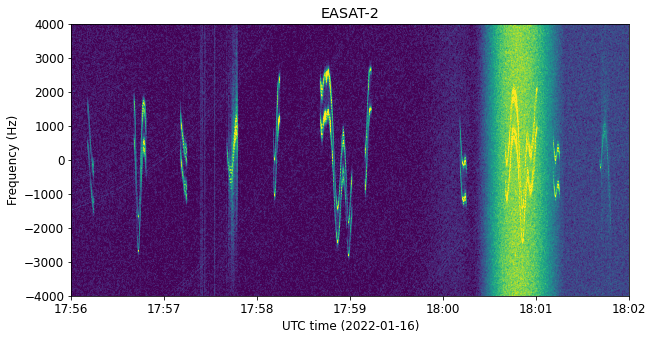

In [12]:
plt.figure(figsize=(10, 5), facecolor='w')
plt.imshow(10*np.log10(f_sat[1]).T[::-1], aspect='auto',
          extent=[mdates.date2num(t0_dt), mdates.date2num(t0_dt + datetime.timedelta(seconds=T)),
                  -fs/2, fs/2],
                  vmin=-3, vmax=12)
plt.ylim((-4000, 4000))
plt.xlim((mdates.date2num(np.datetime64('2022-01-16T17:56:00')),
          mdates.date2num(np.datetime64('2022-01-16T18:02:00'))))
plt.title('EASAT-2')
plt.ylabel('Frequency (Hz)')
plt.gca().xaxis.set_major_locator(MinuteLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.gca().set_xlabel(f'UTC time ({t0_dt.strftime("%Y-%m-%d")})');

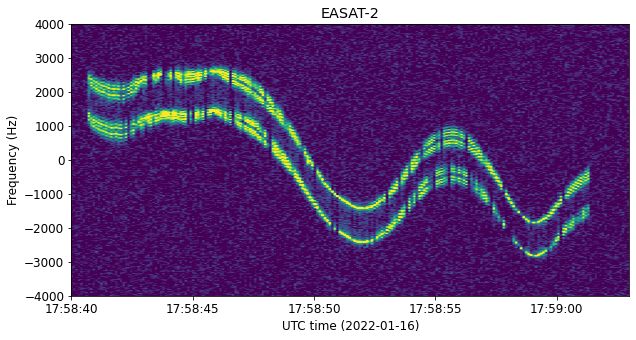

In [13]:
plt.figure(figsize=(10, 5), facecolor='w')
plt.imshow(10*np.log10(f_sat[1]).T[::-1], aspect='auto',
          extent=[mdates.date2num(t0_dt), mdates.date2num(t0_dt + datetime.timedelta(seconds=T)),
                  -fs/2, fs/2],
                  vmin=-3, vmax=17)
plt.ylim((-4000, 4000))
plt.xlim((mdates.date2num(np.datetime64('2022-01-16T17:58:40')),
          mdates.date2num(np.datetime64('2022-01-16T17:59:03'))))
plt.title('EASAT-2')
plt.ylabel('Frequency (Hz)')
plt.gca().xaxis.set_major_locator(SecondLocator(np.arange(0, 60, 5)))
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
plt.gca().set_xlabel(f'UTC time ({t0_dt.strftime("%Y-%m-%d")})');

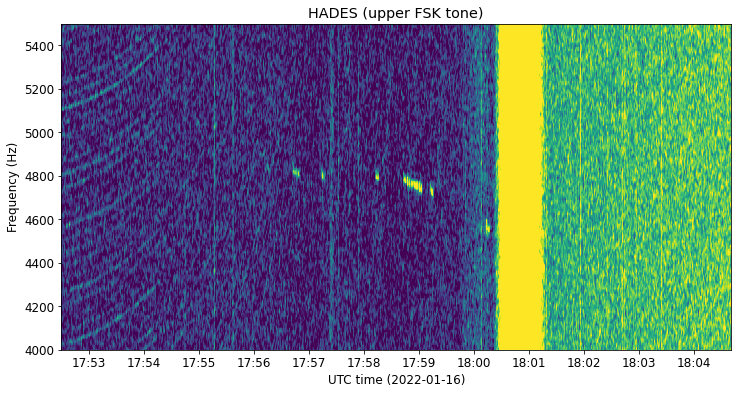

In [14]:
plt.figure(figsize=(12, 6), facecolor='w')
span = 700
plt.imshow(10*np.log10(f_sat[2, :, NFFT//2-span:NFFT//2+span].T[::-1]),
           vmin=-3, vmax=2, aspect='auto',
           extent=[mdates.date2num(t0_dt), mdates.date2num(t0_dt + datetime.timedelta(seconds=T)),
                   -span/NFFT*fs, span/NFFT*fs])
plt.ylim((4000, 5500))
plt.gca().xaxis.set_major_locator(MinuteLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.xlabel(f'UTC time ({t0_dt.strftime("%Y-%m-%d")})')
plt.ylabel('Frequency (Hz)')
plt.title('HADES (upper FSK tone)');

In [15]:
noise_meas = slice(NFFT//2-round(7.5e3/fs*NFFT),
                   NFFT//2-round(4e3/fs*NFFT))
a = round(3e3/fs*NFFT)
sig_meas_0 = slice(NFFT//2-a, NFFT//2+a)
sig_meas_1 = slice(NFFT//2-round(3.5e3/fs*NFFT),
                   NFFT//2+round(6e3/fs*NFFT))

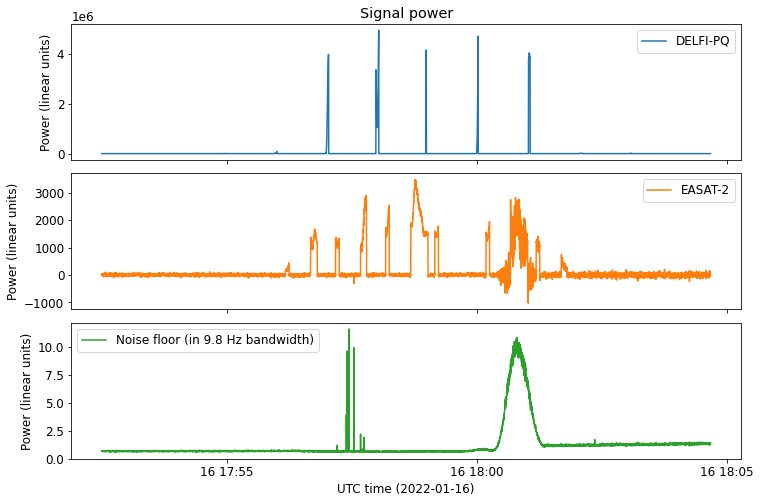

In [16]:
t_np = (
    np.datetime64('1970-01-01')
    + np.timedelta64(1, 'ns') * (t0 * 1e9)
    + np.timedelta64(1, 'ns') * np.arange(f_sat.shape[1]) * (1e9 * NFFT / fs)
)
noise = np.average(f_sat[1, :, noise_meas], axis=-1)
sig0 = np.sum(f_sat[0, :, sig_meas_0], axis=-1) - noise * (sig_meas_0.stop - sig_meas_0.start)
sig1 = np.sum(f_sat[1, :, sig_meas_1], axis=-1) - noise * (sig_meas_1.stop - sig_meas_1.start)
fig, axs = plt.subplots(3, 1, figsize=(12, 8), facecolor='w', sharex=True)
axs[0].plot(t_np, sig0, label=sat_names[0], color='C0')
axs[1].plot(t_np, sig1, label=sat_names[1], color='C1')
axs[2].plot(t_np, noise, label=f'Noise floor (in {fs/NFFT:.02} Hz bandwidth)', color='C2')
for ax in axs:
    ax.set_ylabel('Power (linear units)')
    ax.legend()
plt.subplots_adjust(hspace=0.1)
axs[0].set_title('Signal power')
axs[-1].set_xlabel(f'UTC time ({t0_dt.strftime("%Y-%m-%d")})');

<ipython-input-17-64d4ef3db44f>:2: RuntimeWarning: invalid value encountered in log10
  plt.plot(t_np, 10*np.log10(sig0 * fs/NFFT), '.')
<ipython-input-17-64d4ef3db44f>:3: RuntimeWarning: invalid value encountered in log10
  plt.plot(t_np, 10*np.log10(sig1 * fs/NFFT), '.')


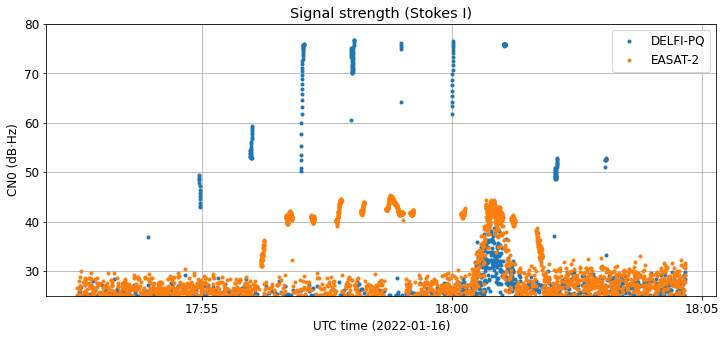

In [17]:
plt.figure(figsize=(12, 5), facecolor='w')
plt.plot(t_np, 10*np.log10(sig0 * fs/NFFT), '.')
plt.plot(t_np, 10*np.log10(sig1 * fs/NFFT), '.')
plt.ylim((25, 80))
plt.grid()
plt.legend(sat_names[:-1])
plt.ylabel('CN0 (dB·Hz)')
plt.title('Signal strength (Stokes I)')
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.xlabel(f'UTC time ({t0_dt.strftime("%Y-%m-%d")})');

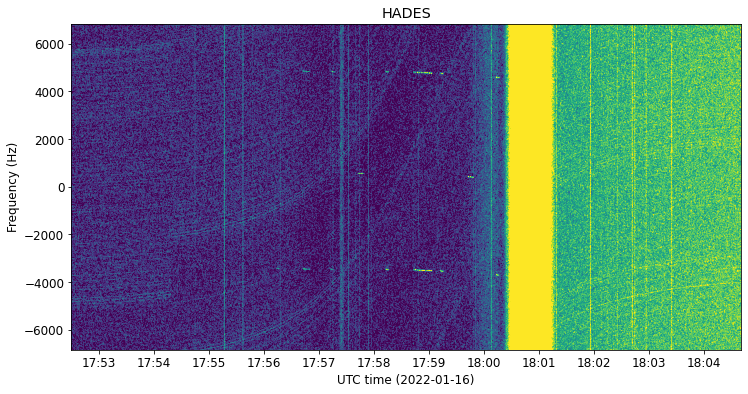

In [18]:
plt.figure(figsize=(12, 6), facecolor='w')
span = 700
plt.imshow(10*np.log10(f_sat[2, :, NFFT//2-span:NFFT//2+span].T[::-1]),
           vmin=-3, vmax=2, aspect='auto',
           extent=[mdates.date2num(t0_dt), mdates.date2num(t0_dt + datetime.timedelta(seconds=T)),
                   -span/NFFT*fs, span/NFFT*fs])
plt.gca().xaxis.set_major_locator(MinuteLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.xlabel(f'UTC time ({t0_dt.strftime("%Y-%m-%d")})')
plt.ylabel('Frequency (Hz)')
plt.title('HADES');

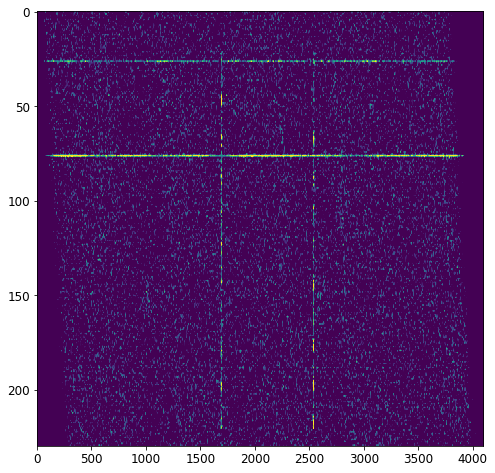

In [19]:
plt.figure(figsize=(8,8))
plt.imshow(10*np.log10(f_sat[2, 3620:3620+230]), vmin=-2, vmax=2,
           aspect='auto')

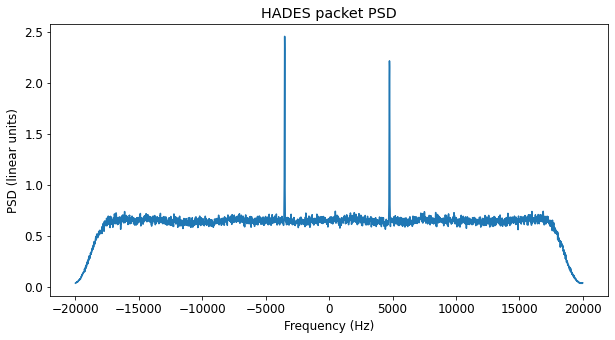

In [20]:
plt.figure(figsize=(10, 5), facecolor='w')
hades_packet = np.average(f_sat[2, 3620+20:3620+220], axis=0)
plt.plot(np.fft.fftshift(np.fft.fftfreq(NFFT, 1/fs)), hades_packet)
plt.title('HADES packet PSD')
plt.ylabel('PSD (linear units)')
plt.xlabel('Frequency (Hz)');

In [21]:
np.where(hades_packet >= 2)

(array([1688, 1689, 1690, 2534, 2535, 2536]),)

In [22]:
a = 1689
b = 2535
L = 10

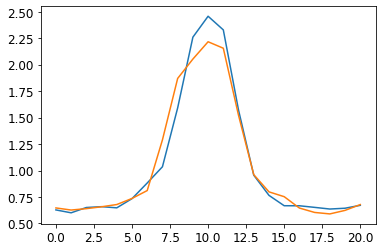

In [23]:
plt.plot(hades_packet[a-L:a+L+1])
plt.plot(hades_packet[b-L:b+L+1])

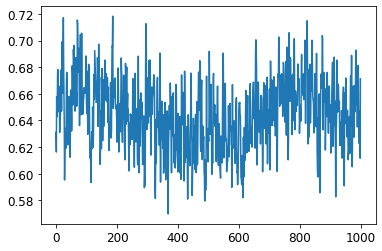

In [24]:
plt.plot(hades_packet[500:1500])

In [25]:
hades_packet_pwr = np.sum(hades_packet[a-L:a+L+1]) + np.sum(hades_packet[b-L:b+L+1])
noise_pwr = np.average(hades_packet[500:1500])
hades_packet_pwr -= noise_pwr * (hades_packet[a-L:a+L+1].size + hades_packet[b-L:b+L+1].size)
hades_packet_pwr

16.15247707018209

In [26]:
hades_cn0 = 10*np.log10(hades_packet_pwr / noise_pwr * fs / NFFT)
hades_cn0

23.88204506157855

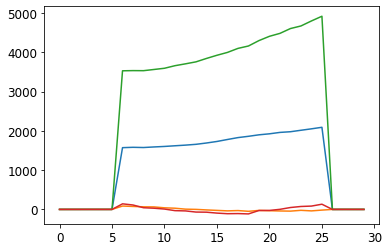

In [27]:
phase_corrs = np.zeros(2, dtype='complex')
for j, k in enumerate([0, 2]):
    g = f[0, :, :, sig_meas_0]
    h = np.sum(g[k] * np.conj(g[k+1]), axis=-1)[4990:5020]
    phase_corrs[j] = np.exp(-1j*np.angle(np.average(h)))
    h *= phase_corrs[j]
    plt.plot(h.real)
    plt.plot(h.imag)

Packet locations need to be selected manually in this code:

```
for sat in [0, 1]:
    packets = (
        [slice(500+j*587, 580+j*587) for j in range(7)] if sat == 0
        else [slice(490, 590), slice(800, 900), slice(900, 1000),
              slice(1080, 1180), slice(1395, 1495), slice(1670, 1770),
              slice(2250, 2350), slice(2575, 2675), slice(2855, 2955),
              slice(3170, 3270), slice(3435, 3535), slice(3755, 3855),
              slice(4035, 4135)])
    fig, axs = plt.subplots(2, len(packets), figsize=(12, 6), facecolor='w',
                            sharey=True, sharex='col')
    for j, k in enumerate([0, 2]):
        g = np.average(np.abs(f_norm[
                sat, k:k+2, :,
                sig_meas_0 if sat == 0 else sig_meas_1])**2, axis=-1)
        I = g[0] + g[1]
        Q = g[0] - g[1]
        g = f_norm[sat, :, :,
                   sig_meas_0 if sat == 0 else sig_meas_1]
        h = np.average(g[k] * np.conj(g[k+1]), axis=-1)
        h *= phase_corrs[k//2]
        U = 2*h.real
        V = -2*h.imag
        g = np.average(np.abs(f_norm[
            1, k:k+2, :, noise_meas])**2, axis=-1)
        I_noise = g[0] + g[1]
        Q_noise = g[0] - g[1]
        g = f_norm[1, :, :, noise_meas]
        h = np.average(g[k] * np.conj(g[k+1]), axis=-1)
        h *= phase_corrs[k//2]
        U_noise = 2*h.real
        V_noise = -2*h.imag
        threshold = 100 if sat == 0 else 1
        sel = I - I_noise >= threshold
        theta = np.rad2deg(np.angle((Q+1j*U)))/2
        theta[~sel] = np.nan
        
        for m, packet in enumerate(packets):
            axs[j, m].plot(t_np, I - I_noise, label='I')
            axs[j, m].plot(t_np, Q - Q_noise, label='Q')
            axs[j, m].plot(t_np, U - U_noise, label='U')
            axs[j, m].plot(t_np, V - V_noise, label='V')
            ax2 = axs[j, m].twinx()
            ax2.plot(t_np, theta, color='grey')
            ax2.set_ylim((-90, 90))
            if m != len(packets) - 1:
                ax2.get_yaxis().set_ticks([])
            else:
                ax2.get_yaxis().set_ticks(np.arange(-90+30, 90, 30))
                ax2.set_ylabel('Angle (deg)')
            axs[j, m].set_xlim((t_np[packet][0], t_np[packet][-1]))
            axs[j, m].xaxis.set_major_locator(SecondLocator(range(0, 60, 5)))
            axs[j, m].tick_params(axis='x', labelrotation=90)
        axs[j, 0].set_ylabel(f'Antenna {"1a" if j == 0 else "1f"}')
    fig.subplots_adjust(hspace=0, wspace=0)
    fig.suptitle(f'Stokes parameters: {sat_names[sat]}', y=0.95)
```